In [1]:
import sys
sys.path.append('../../')
from CMRx4DFlowMaskGeneration import *
sys.path.append('../')
from Utils import *
from einops import rearrange


In [2]:
# Read one case from a folder that contains the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/Aorta/Center012/Philips_30T_Ingenia/vn4/'

# load_data takes the case directory (where the .mat files are located) as input
# Returned objects are lazy h5 handles (h5py-style); data is not loaded into memory until indexed
kdata_full = load_data(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap = load_data(data_dir + '/coilmap.mat', key='coilmap')
segmask = load_data(data_dir + '/segmask.mat', key='segmask')
params = read_params_csv(data_dir + '/params.csv')

# For h5 datasets, use [()] to materialize the full array into RAM as a NumPy array
kdata_full = kdata_full['real'][()] + 1j * kdata_full['imag'][()]

# k-space data shape: (Nv, Nt, SPE, PE, FE)
Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape

Mask shape: (1, 25, 1, 20, 96, 1), Actual undersampling rate: 20.00x


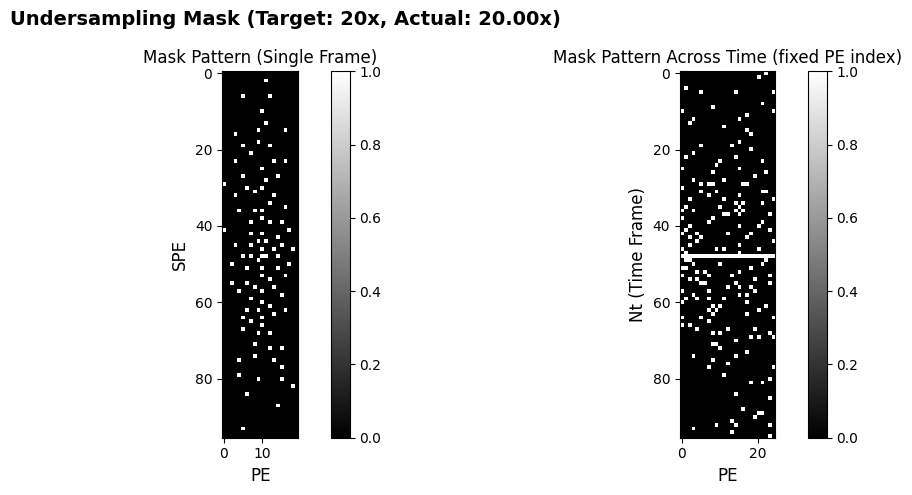

In [3]:
usrate = 20
# target number of sampled points per (PE,SPE) frame
total_points = PE * SPE // usrate

# fun_mask_gen_2d expects mask_size = (PE, SPE)
mask_size = (PE, SPE)

# fully-sampled center control (in your implementation: <=0.5 means force center point = 1)
center_radius_x = 0.5
center_radius_y = 0.5

# Gaussian sampling density (larger -> flatter; smaller -> more center-focused)
sigma_x = PE / 5
sigma_y = SPE / 5

# Generate masks for all time frames:
# output shape is (SPE, PE, Nt)
masks_spe_pe_t = fun_mask_gen_2d(
    mask_size=mask_size,
    center_radius_x=center_radius_x,
    center_radius_y=center_radius_y,
    total_points=total_points,
    pattern_num=Nt,
    sigma_x=sigma_x,
    sigma_y=sigma_y,
    min_dist_factor=3,
    rep_decay_factor=0.5,
)
# Reshape to match the document:
# (SPE, PE, Nt) -> (1, Nt, 1, SPE, PE, 1)
usmask = rearrange(masks_spe_pe_t, 'spe pe t -> 1 t 1 spe pe 1')
actual_usrate = 1.0 / np.mean(usmask)
print(f"Mask shape: {usmask.shape}, Actual undersampling rate: {actual_usrate:.2f}x")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    f'Undersampling Mask (Target: {usrate}x, Actual: {actual_usrate:.2f}x)',
    fontsize=14,
    fontweight='bold'
)
# Show one time frame mask: (SPE, PE)
im0 = axes[0].imshow(usmask[0, 0, 0, :, :, 0].T, cmap='gray')
axes[0].set_xlabel("PE", fontsize=12)
axes[0].set_ylabel("SPE", fontsize=12)
axes[0].set_title("Mask Pattern (Single Frame)", fontsize=12)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Show temporal variation at one SPE line: (Nt, PE)
im1 = axes[1].imshow(usmask[0, :, 0, SPE//2, :, 0].T, cmap='gray')
axes[1].set_xlabel("PE", fontsize=12)
axes[1].set_ylabel("Nt (Time Frame)", fontsize=12)
axes[1].set_title("Mask Pattern Across Time (fixed PE index)", fontsize=12)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

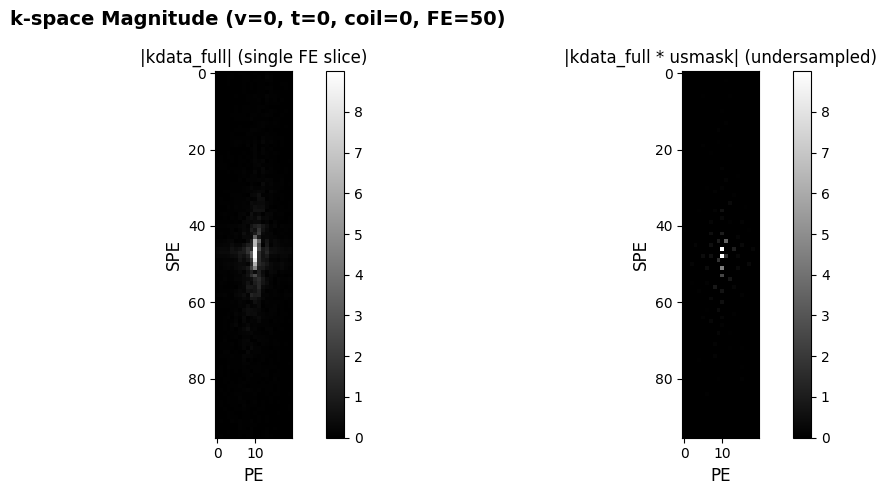

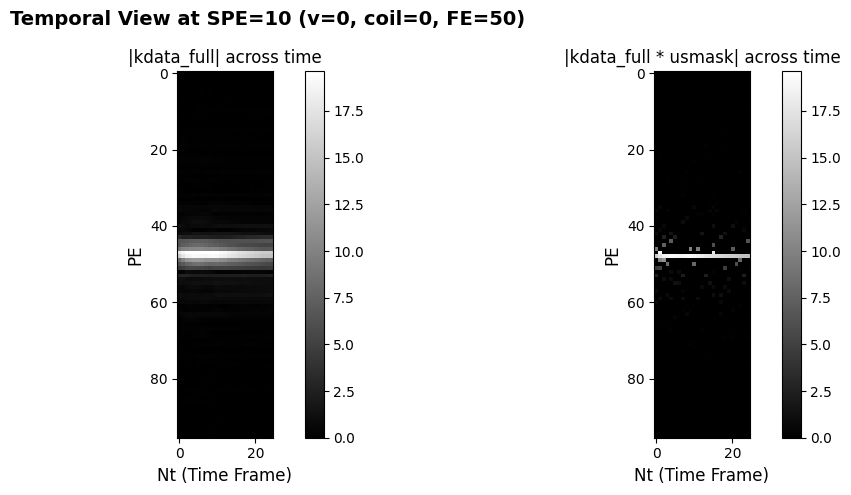

In [4]:
kdata_us = kdata_full * usmask

v_idx = 0
t_idx = 0
c_idx = 0
fe_idx = FE // 2

# magnitude (no log transform)
full_mag = np.abs(kdata_full[v_idx, t_idx, c_idx, :, :, fe_idx]).T
us_mag   = np.abs(kdata_us  [v_idx, t_idx, c_idx, :, :, fe_idx]).T

# choose a log-like display range by setting clim from percentiles (robust), shared for both
# (this is "log-ish" in effect without transforming the data)
vmin, vmax = np.percentile(np.concatenate([full_mag.ravel(), us_mag.ravel()]), [1, 99.9])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    f'k-space Magnitude (v={v_idx}, t={t_idx}, coil={c_idx}, FE={fe_idx})',
    fontsize=14,
    fontweight='bold'
)

im0 = axes[0].imshow(full_mag, cmap='gray')
im0.set_clim(vmin, vmax)
axes[0].set_xlabel("PE", fontsize=12)
axes[0].set_ylabel("SPE", fontsize=12)
axes[0].set_title("|kdata_full| (single FE slice)", fontsize=12)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(us_mag, cmap='gray')
im1.set_clim(vmin, vmax)
axes[1].set_xlabel("PE", fontsize=12)
axes[1].set_ylabel("SPE", fontsize=12)
axes[1].set_title("|kdata_full * usmask| (undersampled)", fontsize=12)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()


# Temporal view (Nt x PE) at fixed SPE index (no log transform)
spe_idx = SPE // 2
full_t = np.abs(kdata_full[v_idx, :, c_idx, spe_idx, :, fe_idx]).T  # (PE, Nt)
us_t   = np.abs(kdata_us  [v_idx, :, c_idx, spe_idx, :, fe_idx]).T  # (PE, Nt)

vmin_t, vmax_t = np.percentile(np.concatenate([full_t.ravel(), us_t.ravel()]), [1, 99.9])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(
    f'Temporal View at SPE={spe_idx} (v={v_idx}, coil={c_idx}, FE={fe_idx})',
    fontsize=14,
    fontweight='bold'
)

im0 = axes[0].imshow(full_t, cmap='gray')
im0.set_clim(vmin_t, vmax_t)
axes[0].set_xlabel("Nt (Time Frame)", fontsize=12)
axes[0].set_ylabel("PE", fontsize=12)
axes[0].set_title("|kdata_full| across time", fontsize=12)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(us_t, cmap='gray')
im1.set_clim(vmin_t, vmax_t)
axes[1].set_xlabel("Nt (Time Frame)", fontsize=12)
axes[1].set_ylabel("PE", fontsize=12)
axes[1].set_title("|kdata_full * usmask| across time", fontsize=12)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()